In [282]:
# Import calibration functions
# Run this to reimport without having to restart the whole notebook
import radial_velocity_functions
import importlib
importlib.reload(radial_velocity_functions)
from radial_velocity_functions import *

In [257]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = 10 
matplotlib.rcParams['figure.dpi'] = 200

### First : order overlap

We find the same feature many times, because there is a lot of overlap between the orders. The overlap decreases with increasing order.

1267 peaks found


Text(0, 0.5, 'Feature')

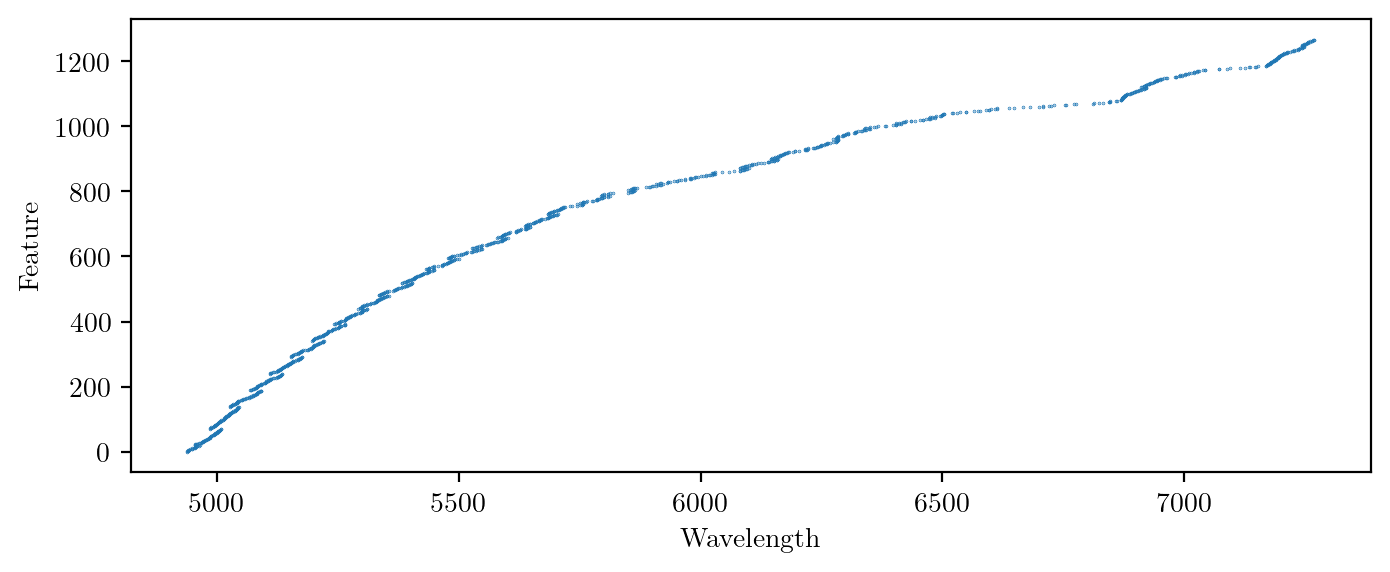

In [3]:
# Plot all features  
d1 = find_features(get_all_spectra_filenames()[0], order_padding=0)
feature_peak_wavel = [d1[i][3] for i in range(len(d1))]
plt.figure(figsize=(8,3))
plt.plot(feature_peak_wavel, np.arange(len(feature_peak_wavel)), ".", ms=0.5)
plt.xlabel("Wavelength")
plt.ylabel("Feature")

An easy fix is just to trim off the wavelengths at the beginning of each order, which appeared at the end of the previous order. Here done in the find_features() method with the parameter apply_order_overlap_masking=True.

879 peaks found


Text(0, 0.5, 'Feature')

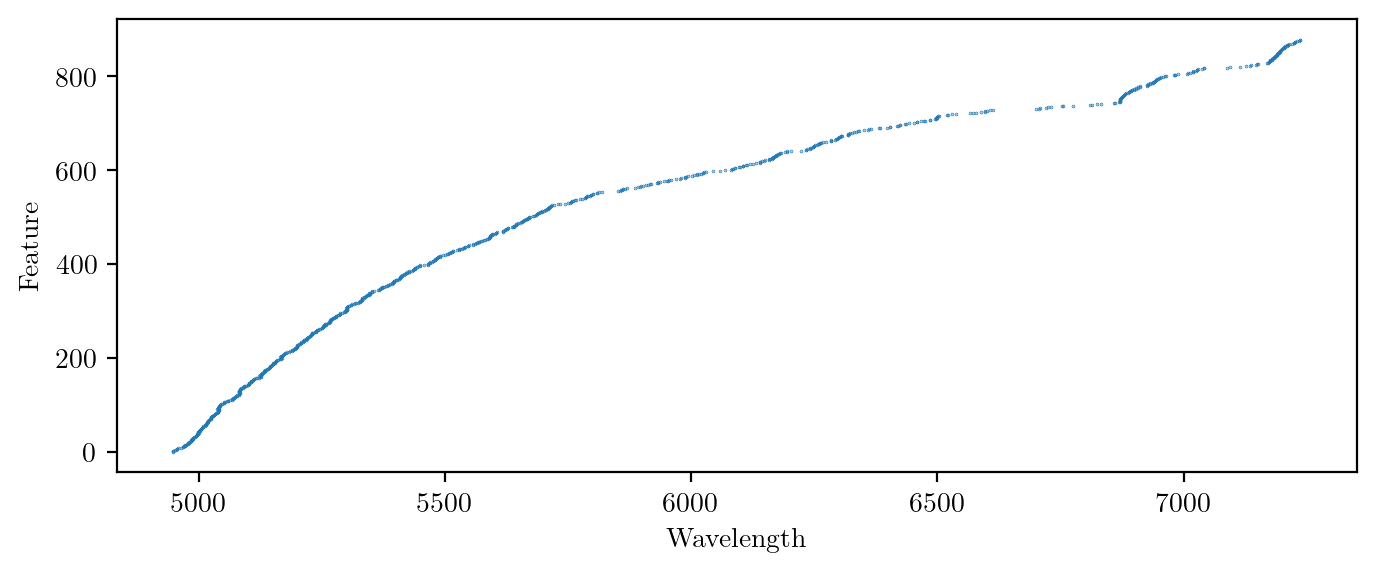

In [4]:
# Plot all features  
d1 = find_features(get_all_spectra_filenames()[0], apply_order_overlap_masking=True)
feature_peak_wavel = [d1[i][3] for i in range(len(d1))]
plt.figure(figsize=(8,3))
plt.plot(feature_peak_wavel, np.arange(len(feature_peak_wavel)), ".", ms=0.5)
plt.xlabel("Wavelength")
plt.ylabel("Feature")

## New approach to finding features across all observations

In [276]:
filenames = get_spectra_filenames_without_duplicate_dates(SPECTRA_PATH_34411)
days = convert_dates_to_relative_days(get_spectra_dates(filenames))

In [283]:
all_features = [find_features(file, log=False, apply_order_overlap_masking=True, corect_for_tellurics=True) for file in filenames]

In [284]:
# Extract wavelength of all features
feature_wavelengths = []
for f in all_features:
    list = [f[i][3] for i in range(len(f))]
    feature_wavelengths.append(list)
feature_wavelengths = np.concatenate(feature_wavelengths)

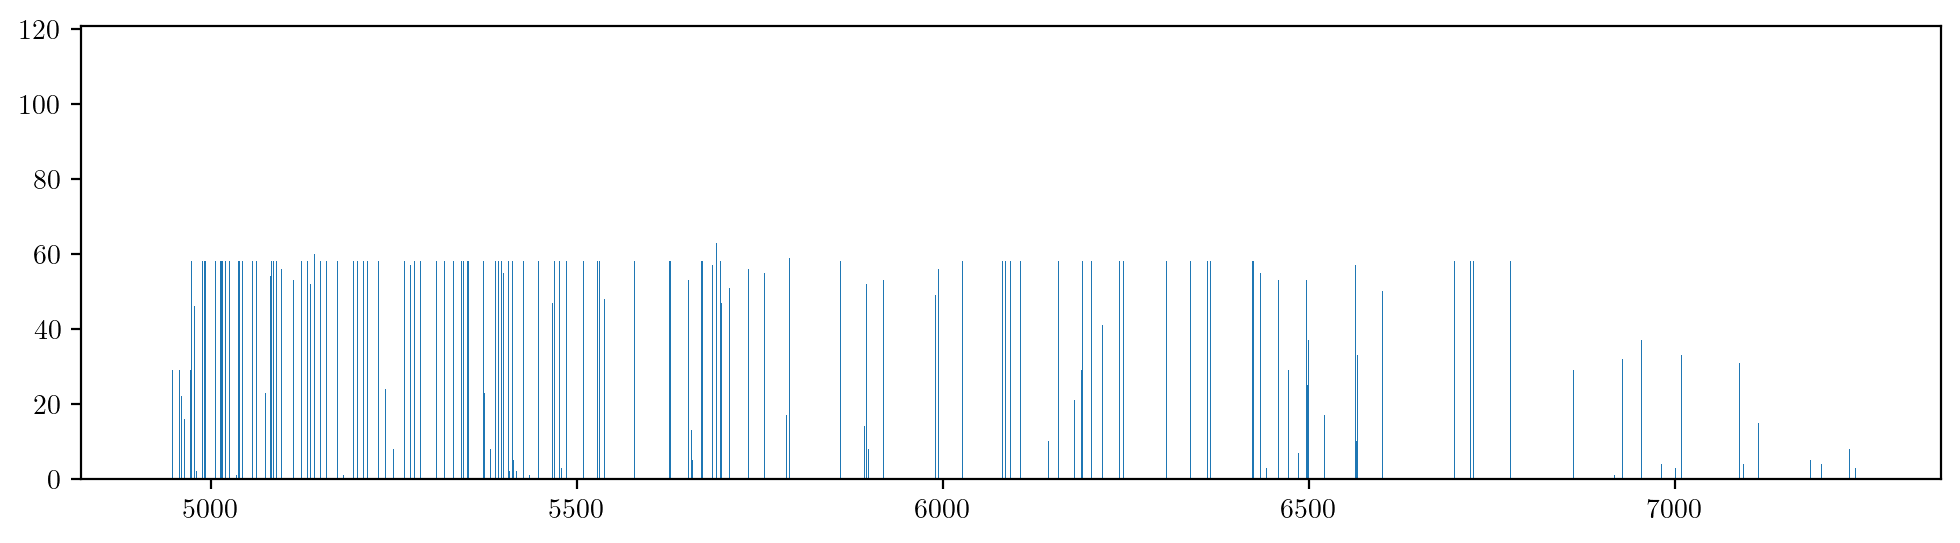

In [285]:
fig, ax = plt.subplots(figsize=(12,3))
ax.hist(feature_wavelengths, bins=10000);

In [286]:
# Do numpy histogram instead to get count and bin_edges with larger bin size
xmin, xmax = np.min(feature_wavelengths), np.max(feature_wavelengths)
Nbins = 100000
count, bin_edges = np.histogram(feature_wavelengths, bins=Nbins, range=(xmin, xmax))
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
bin_width = (xmax-xmin)/Nbins

# # remove features that are overlaping 
# count[np.where(count > 60)] = 0
# with apply_order_overlap_masking=True we don't get overlapping features anymore

# remove features that are not present throughout most observations (50+)
count[np.where(count < 50)] = 0

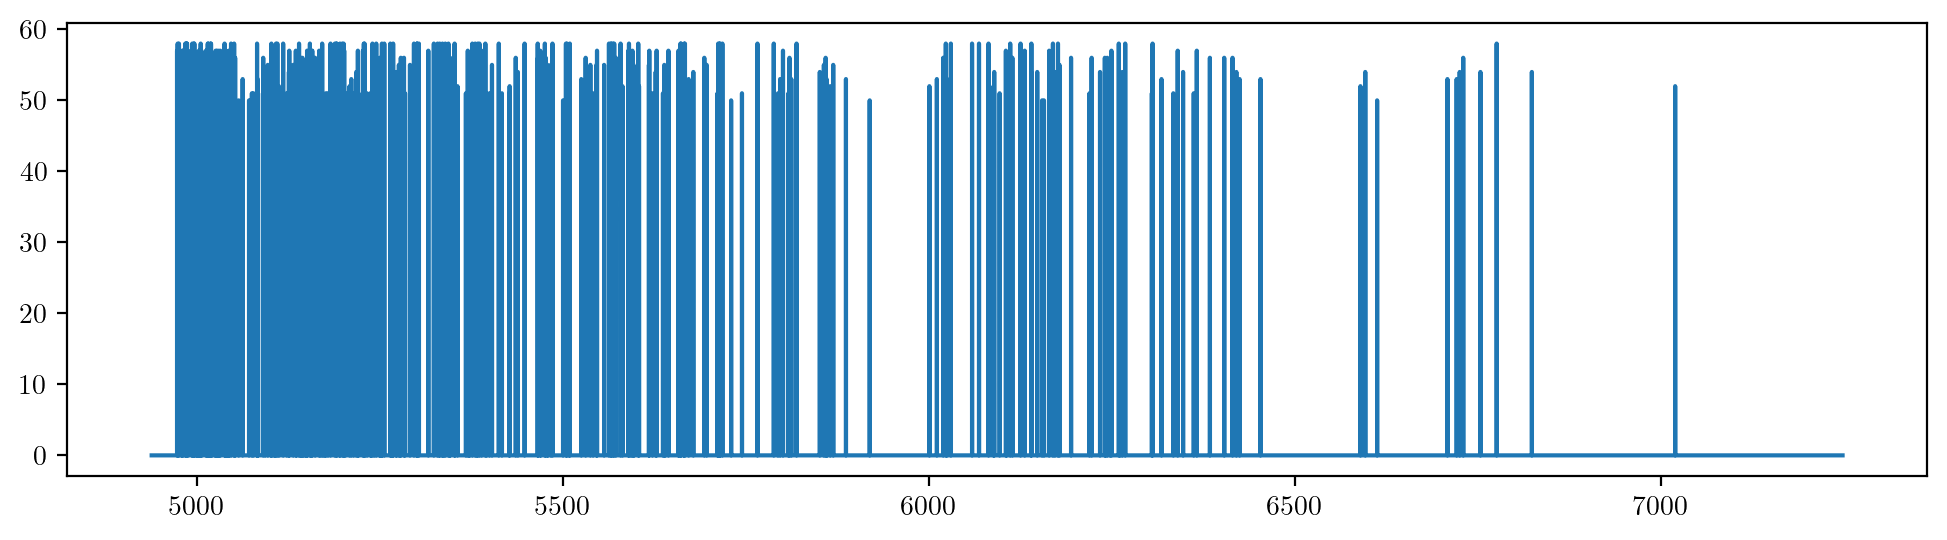

In [287]:
plt.figure(figsize=(12,3))
plt.plot(bin_centers, count)
# plt.xlim(5000, 5100)

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
[findpeaks] >Interpolating 1d-vector by factor 10
320 peaks found


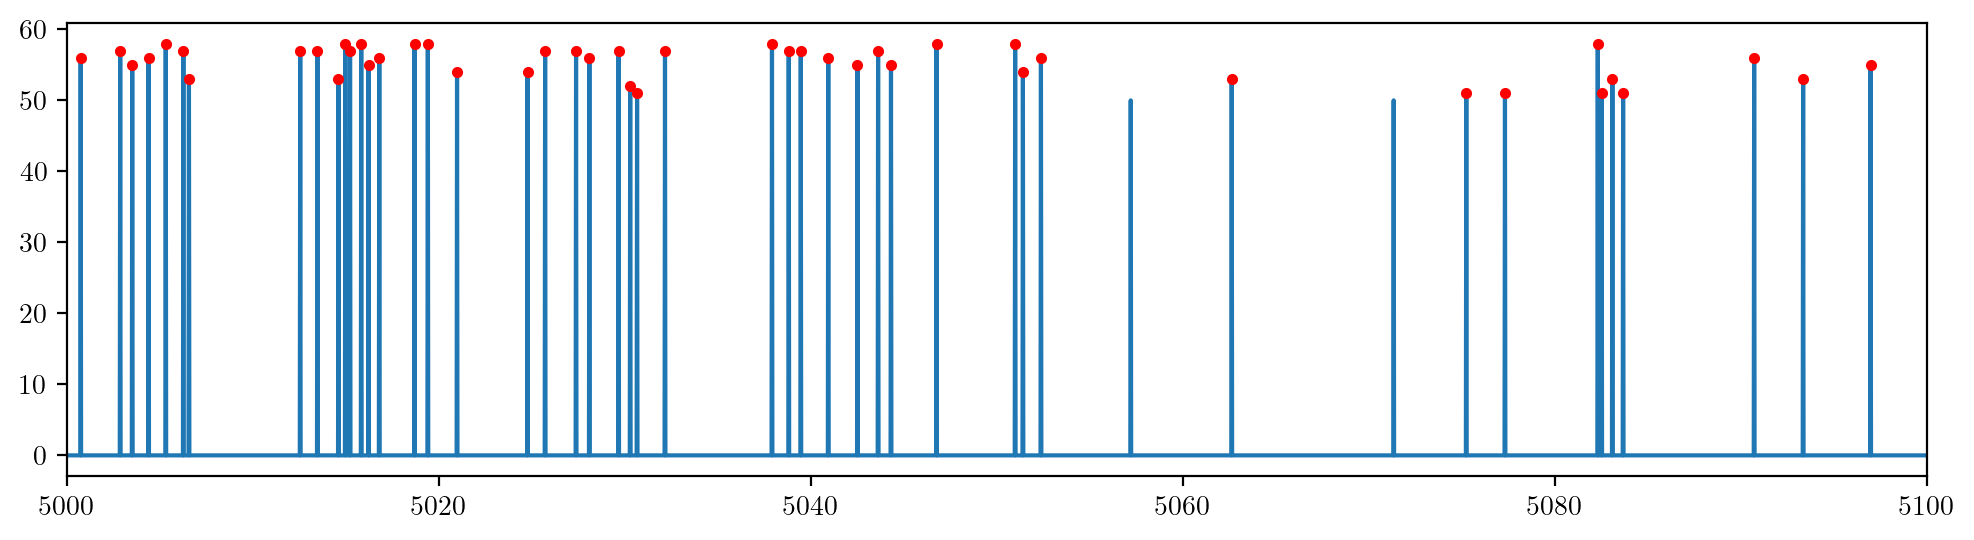

In [288]:
from findpeaks import findpeaks

# Find some peaks using the smoothing parameter.
fp = findpeaks(lookahead=1, interpolate=10) # todo: what do these values do? 
results = fp.fit(count)

# get df from results
res_df = results["df"]

# exclude points that are not peaks (such as valleys)
res_df = res_df[res_df.peak]

# get peak index and height
peak_index = res_df.x 
peak_height = res_df.y 

# Remove "peaks" that are below 50 (a lot around zero...)
peak_index = peak_index[peak_height > 50]
peak_height = peak_height[peak_height > 50]

# get wavelength of bin-centers
peak_wavelength = bin_centers[peak_index]

print(f"{len(peak_index)} peaks found")

# Plot
plt.figure(figsize=(12,3))
plt.plot(bin_centers, count)
plt.xlim(5000, 5100)
plt.plot(peak_wavelength, peak_height, ".", color="red")

889 peaks found


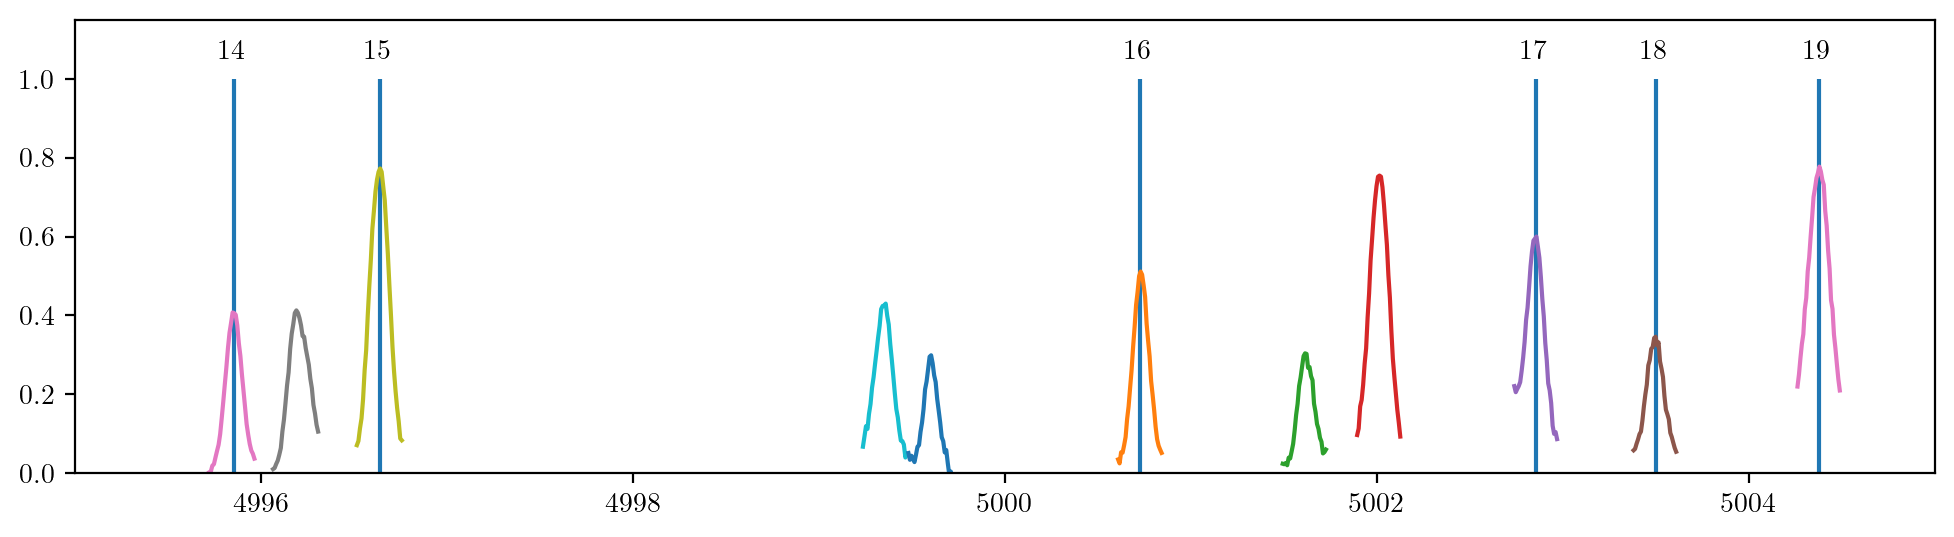

In [289]:
# Plot features on top of determined wavelengths
d1 = find_features(filenames[3], apply_order_overlap_masking=True)
wavel = [d1[i][0] for i in range(len(d1))]
intensity = [d1[i][1] for i in range(len(d1))]

fig, ax = plt.subplots(figsize=(12,3))
# fig, ax = plt.subplots(figsize=(150,3))
ax.set_xlim(4995, 5005)
ax.set_ylim(0, 1.15)

# Plot k wavelenghts with labels
ax.vlines(peak_wavelength, 0, 1)
for i, p in enumerate(peak_wavelength):
    ax.annotate(i, (p, 1), xytext=(p-0.08, 1.05))

# Plot features
for w, I in zip(wavel, intensity):
    # ax.plot(w, I, ".", ms=1)
    ax.plot(w, I)

Now we have a list of all the wavelengths. We can name each of these wavelength with a unique id, $k$, and we can then go back into each observation and find the features that match with the wavelengths. Going through all observations and grouping features by wavelength $k$. 

In [290]:
# Make dataframe of all features
df_all_features = []
for obs, day, i in zip(all_features, days, range(len(all_features))):
    for f in obs:
        fdf = pd.DataFrame({
            "k": np.nan,   # add k, ready to assign 
            "obs": i,
            "day": day,
            "x": [f[0]],
            "y": [f[1]],
            "y_err": [f[2]],
            "x_peak": f[3],
            "x_peak_index": f[4],
            "order": f[5]
        })
        df_all_features.append(fdf)

df_all_features = pd.concat(df_all_features, ignore_index=True)

In [291]:
# df_all_features

In [292]:
# Loop through all features
for i in range(len(df_all_features)):
    
    # get feature peak (wavelength)
    feature_peak = df_all_features.iloc[i].x_peak
    
    # loop through all k wavelengths
    for k, λ in enumerate(peak_wavelength):

        # check if feature peak is in the bin of wavelength k, if so asign. 
        if λ > feature_peak - bin_width and λ < feature_peak + bin_width:
            df_all_features.loc[i, "k"] = k
            break

In [293]:
print(f"We have labeled {len(df_all_features[df_all_features.k > 0])} with k {(len(df_all_features[df_all_features.k > 0])/len(df_all_features) * 100):.3}% of the found features")

We have labeled 18406 with k 43.8% of the found features


In [294]:
# print extract of k 
np.asarray(df_all_features.k)[0:200]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  0.,
        1.,  2., nan, nan,  3.,  4., nan,  5.,  6.,  7.,  8.,  9., 10.,
       nan, 11., nan, nan, nan, 12., 13., 14., nan, 15., nan, nan, 16.,
       nan, nan, 17., 18., 19., 20., 21., 22., nan, nan, nan, nan, 23.,
       24., 25., 26., 27., 28., 29., 30., nan, 31., nan, 32., nan, 33.,
       nan, nan, 34., nan, 35., nan, 36., 37., 38., 39., 40., 41., nan,
       nan, 42., nan, 43., nan, 44., 45., nan, nan, 46., 47., 48., nan,
       49., 50., 51., 52., nan, nan, nan, nan, 53., nan, nan, nan, nan,
       nan, nan, nan, 54., 55., nan, nan, nan, 56., 57., 58., 59., nan,
       nan, nan, nan, 60., nan, nan, 61., 62., nan, nan, 63., nan, 64.,
       65., 66., 67., nan, 68., 69., nan, 70., nan, nan, nan, 71., 72.,
       nan, 73., 74., nan, nan, nan, 75., nan, nan, nan, nan, nan, 76.,
       77., 78., nan, nan, 79., 80., nan, 81., nan, 82., 83., na

So now we can plot all observations of feature k, let's look at k = 1.

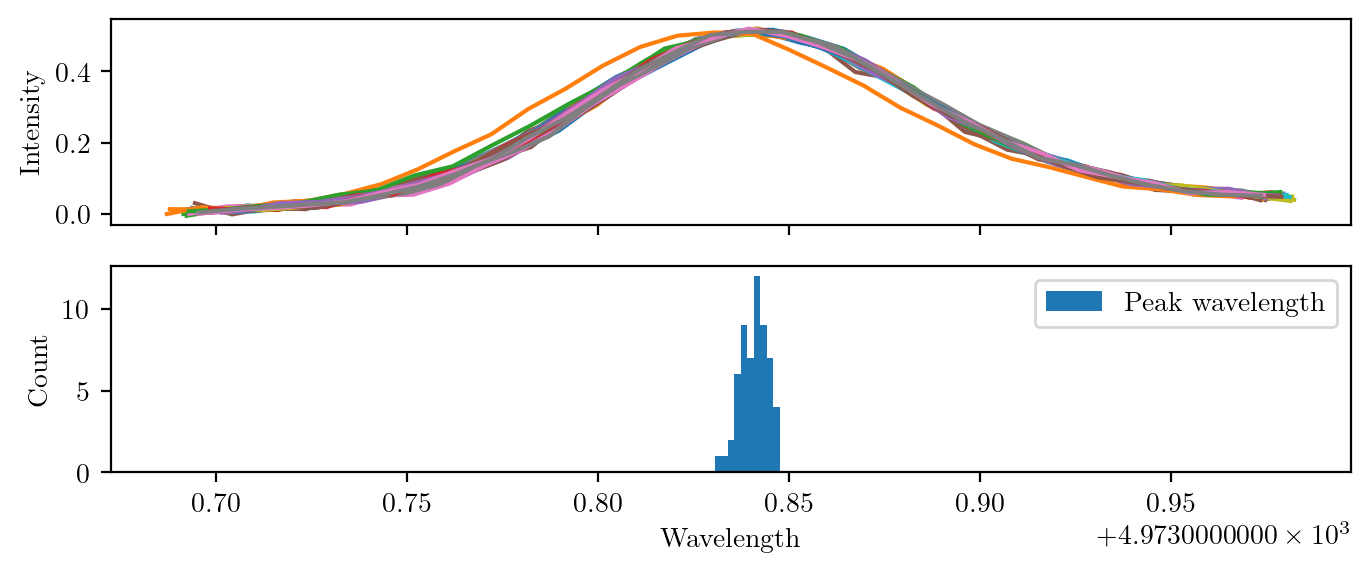

In [295]:
df_f1 = df_all_features[df_all_features.k == 1]
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8,3), sharex=True)
for i in range(len(df_f1)):
    ax1.plot(df_f1.iloc[i].x, df_f1.iloc[i].y)

ax2.hist(df_f1.x_peak, bins=10, label="Peak wavelength");
ax2.set_xlabel("Wavelength")
ax1.set_ylabel("Intensity")
ax2.set_ylabel("Count")
ax2.legend()

,shift,err,valid
0,25.937072,2.090026,True


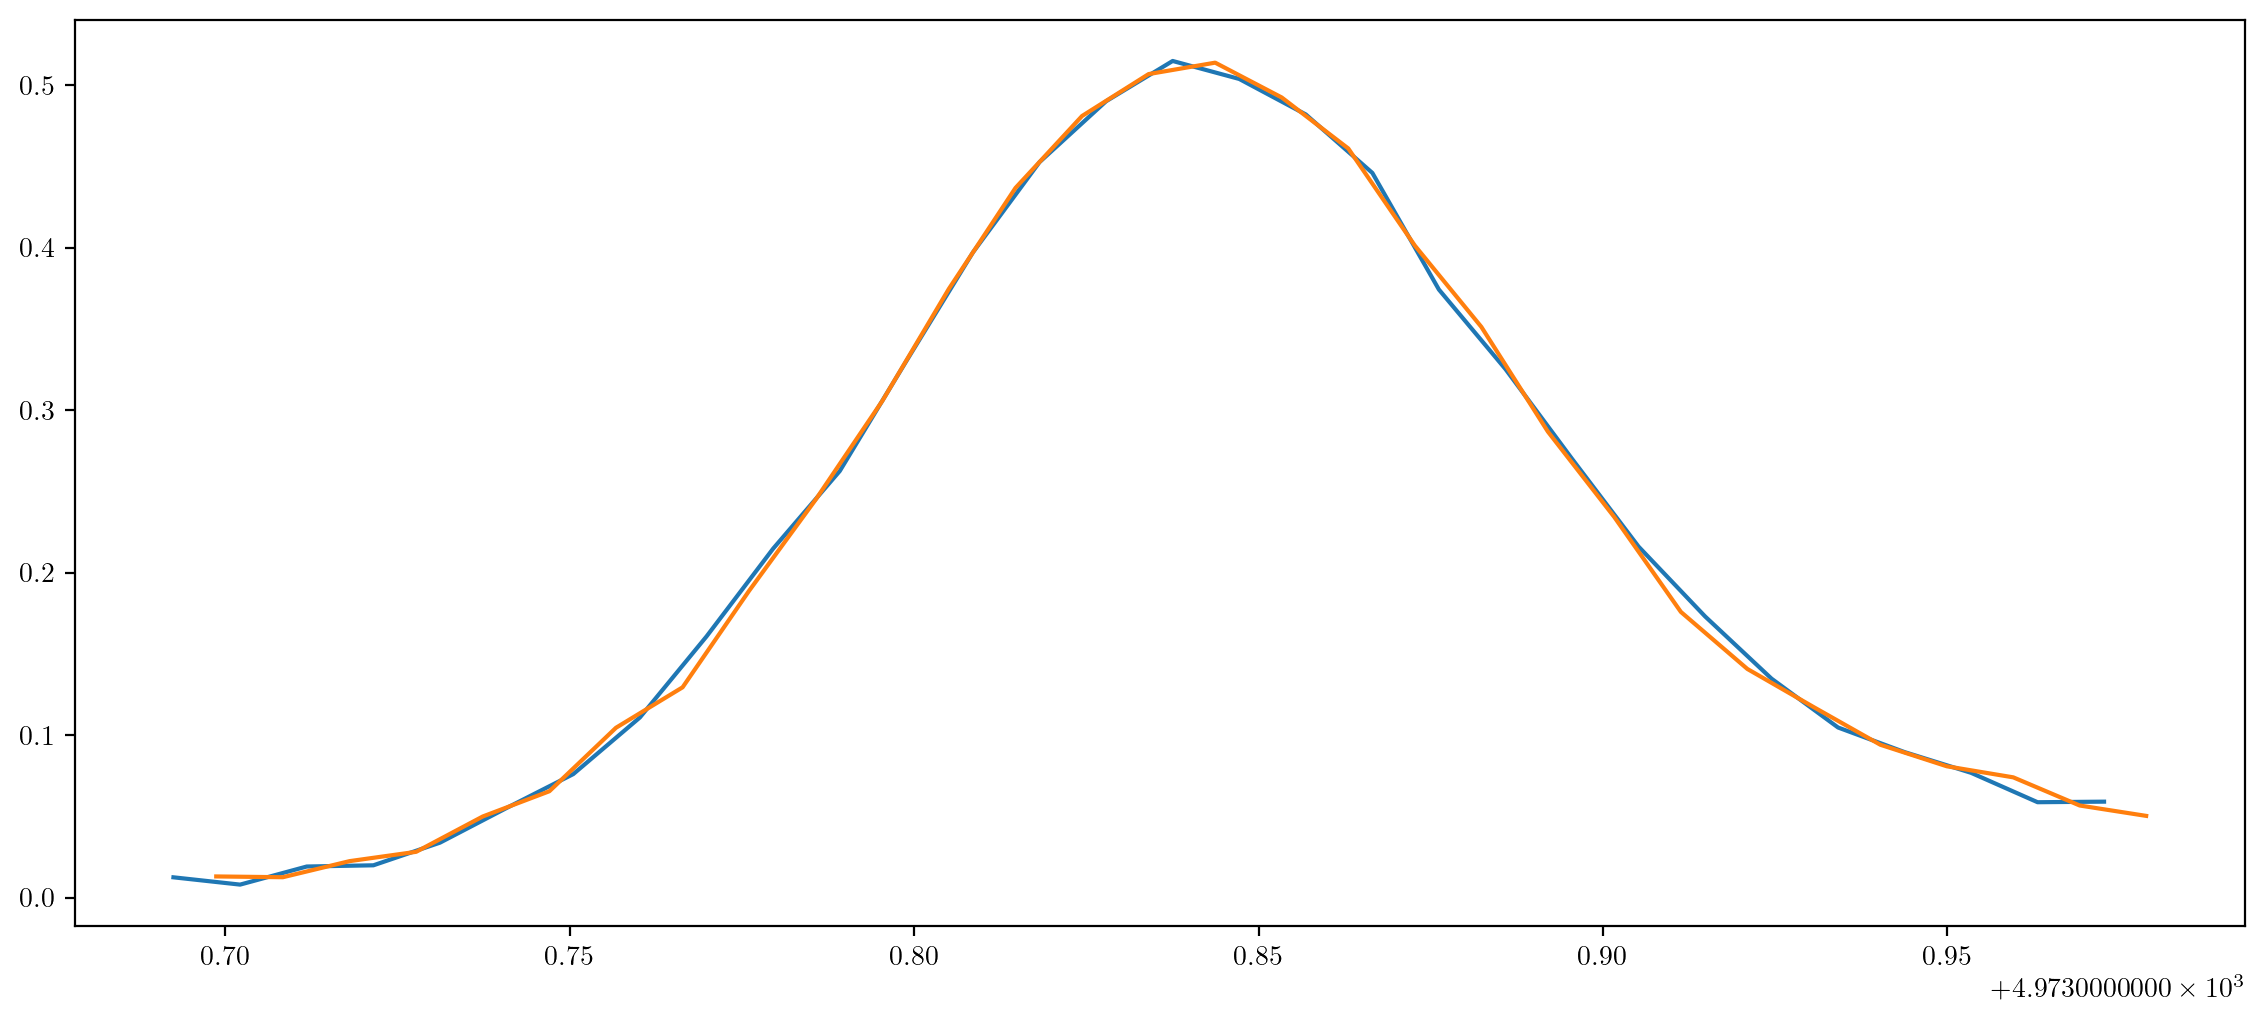

In [296]:
# now we can compute the shift for two observations
f1 = df_f1.iloc[0]
f2 = df_f1.iloc[1]
compute_feature_shift(f1.x, f1.y, f1.y_err, f1.x_peak, f2.x, f2.y, f2.x_peak, plot=True, interp_size = 1000, return_df=True, return_extra=True)


### Compute matrix for feature k=1

In [297]:
df_feature_n = df_all_features[df_all_features.k == 1]

# Setup coords :: Compute one list of coords
coords = compute_coords(len(filenames))
        
# Define function for each process
def compute(coords):
    x, y = coords[0], coords[1]
    f1 = df_feature_n.iloc[x]
    f2 = df_feature_n.iloc[y]
    shifts = compute_feature_shift(f1.x, f1.y, f1.y_err, f1.x_peak, f2.x, f2.y, f2.x_peak, plot=False, interp_size = 1000, return_df=False, return_extra=True)
    return shifts

if __name__ == '__main__':
    import multiprocess
    pool = multiprocess.Pool(processes = 6)
    
    result = []
    print("Computing shifts for all files combinations...")
    for r in tqdm(pool.imap_unordered(compute, coords), total=len(coords)):
        result.append(r)
        
    # np.save(RV_RESULTS_PATH + save_as, [result, coords])
    print("Finished!")

result = np.asarray(result)

Computing shifts for all files combinations...


100%|██████████| 1653/1653 [00:01<00:00, 1634.85it/s]

Finished!


In [298]:
def parse_matrix_results_feature(result, coords):
    
    size = np.max(np.max(coords)) + 1
    diff_matrix, diff_matrix_err, diff_matrix_valid = make_nan_matrix(size), make_nan_matrix(size), make_nan_matrix(size)

    for coord, shifts in zip(coords, result):

        # Split 
        rv, err, valid = shifts[0], shifts[1], shifts[2]

        x = coord[0]
        y = coord[1]

        diff_matrix[x, y] = rv
        diff_matrix_err[x, y] = err
        diff_matrix_valid[x, y] = valid
        
    return diff_matrix, diff_matrix_err, diff_matrix_valid


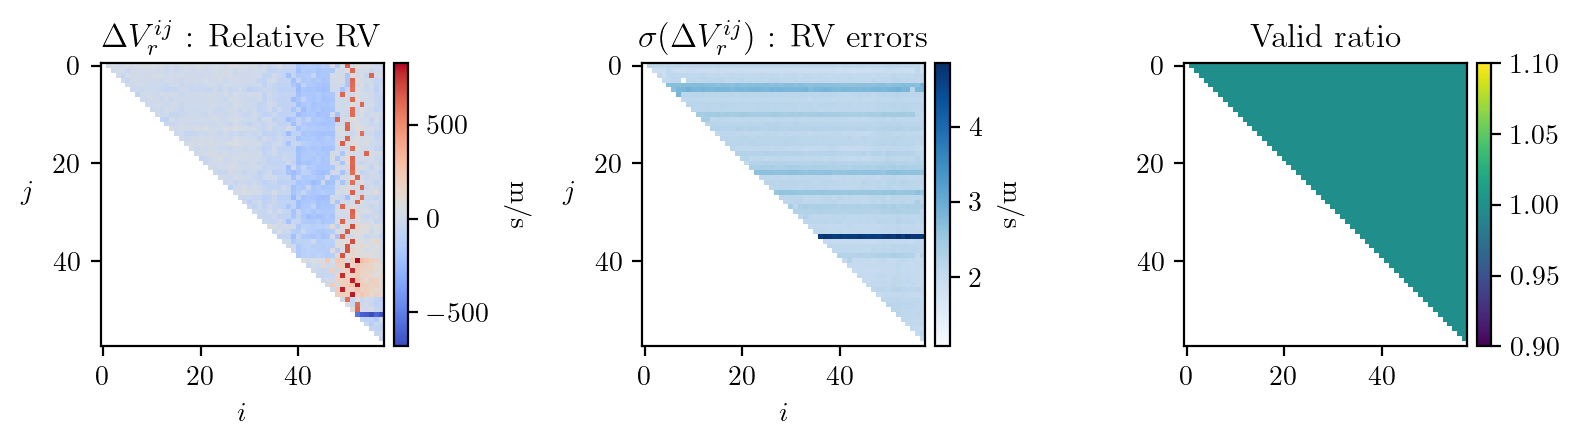

In [299]:
diff_matrix, diff_matrix_err, diff_matrix_valid = parse_matrix_results_feature(result, coords)
plot_matrix(diff_matrix, diff_matrix_err, diff_matrix_valid, plot_ratio=True, kms=False)

In [300]:
m, final_shifts, final_shifts_err, days = matrix_reduce(diff_matrix, diff_matrix_err, diff_matrix_valid, SPECTRA_PATH_34411, plot=False, with_date_duplicates=False, center_around_zero=True)

Text(0, 0.5, 'RV [m/s]')

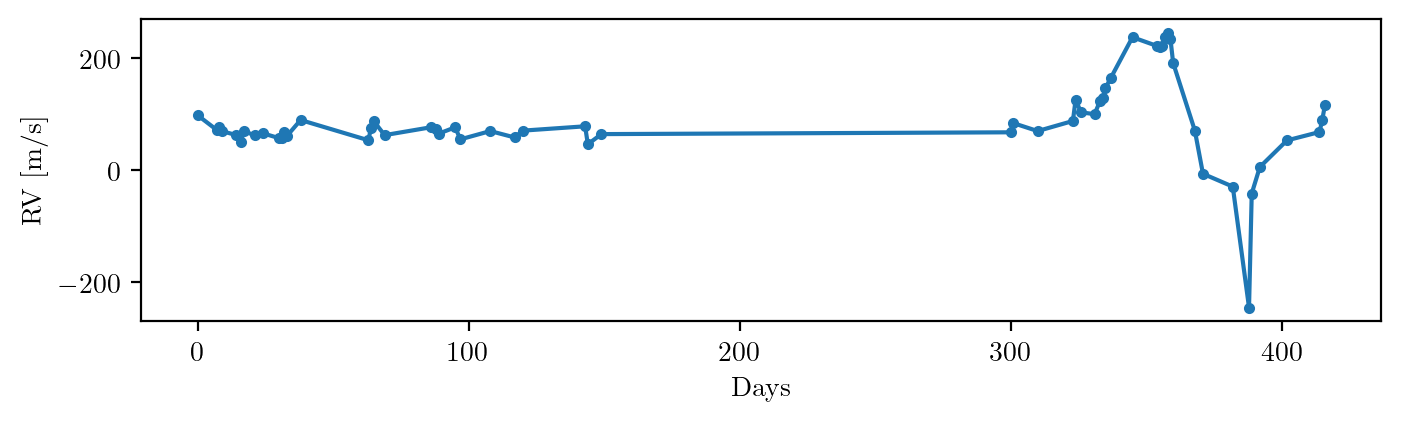

In [301]:
plt.figure(figsize=(8,2))
plt.plot(days, final_shifts, ".-")
plt.xlabel("Days")
plt.ylabel("RV [m/s]")

## Compute for all features

In [302]:
k_list = np.arange(np.max(df_all_features.k))
        
# Define function for each process
def compute(k):

    # get feature
    df_feature_k = df_all_features[df_all_features.k == k]

    # get coords for this feature
    coords_list = compute_coords(len(df_feature_k))
    
    # compute shifts
    feature_result = []
    for coords in coords_list:
        x, y = coords[0], coords[1]
        f1 = df_feature_k.iloc[x]
        f2 = df_feature_k.iloc[y]
        shifts = compute_feature_shift(f1.x, f1.y, f1.y_err, f1.x_peak, f2.x, f2.y, f2.x_peak, plot=False, interp_size = 1000, return_df=False, return_extra=True)
        feature_result.append(shifts)
        
    # reduce matrix
    m, final_shifts, final_shifts_err, _ = matrix_reduce(*parse_matrix_results_feature(feature_result, coords_list), SPECTRA_PATH_34411, plot=False, with_date_duplicates=False, center_around_zero=True)
    
    # get observations days specific to feature k
    feature_k_days = np.asarray(df_feature_k.day)

    return [final_shifts, final_shifts_err, feature_k_days]


if __name__ == '__main__':
    import multiprocess
    pool = multiprocess.Pool(processes = 6)
    
    result = []
    print("Computing shifts for all files combinations...")
    for r in tqdm(pool.imap_unordered(compute, k_list), total=len(k_list)):
    # for r in pool.imap_unordered(compute, k_list):
        result.append(r)
        
    # np.save(RV_RESULTS_PATH + "HD34411_k_shifts.npy", [result, coords])
    print("Finished!")

result = np.asarray(result)



Computing shifts for all files combinations...


100%|██████████| 319/319 [08:04<00:00,  1.52s/it]

Finished!


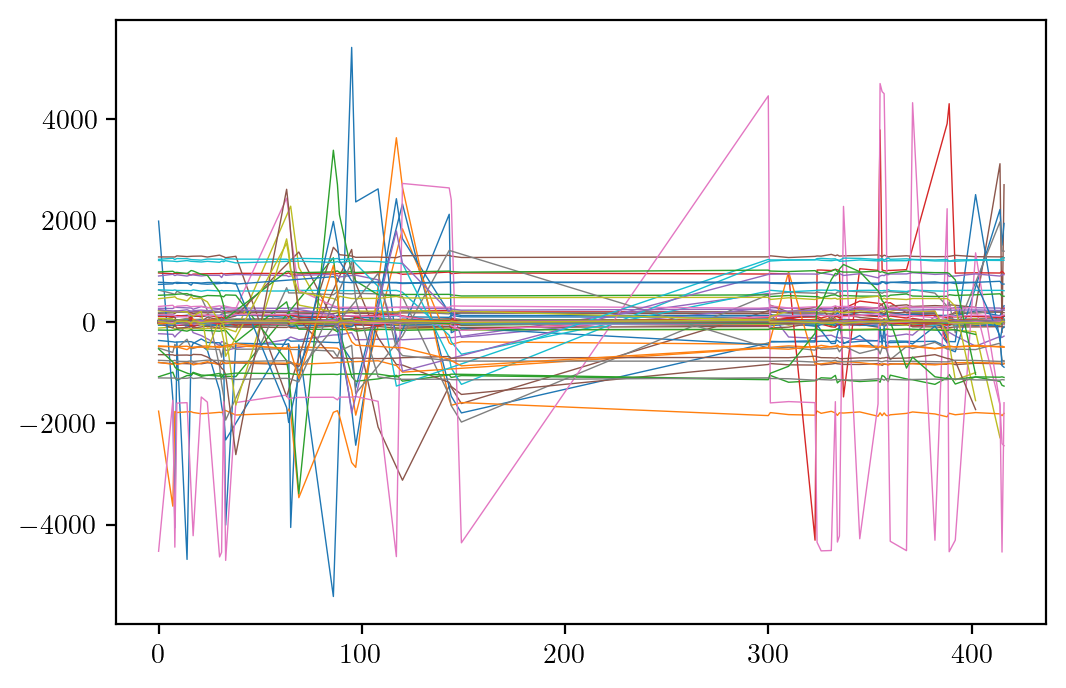

In [303]:
# WITHOUT TELLURICS
for i in range(len(result)):
    # plt.plot(result[i][2], result[i][0], ".-", lw=1, ms=4)
    plt.plot(result[i][2], result[i][0], lw=0.5,)


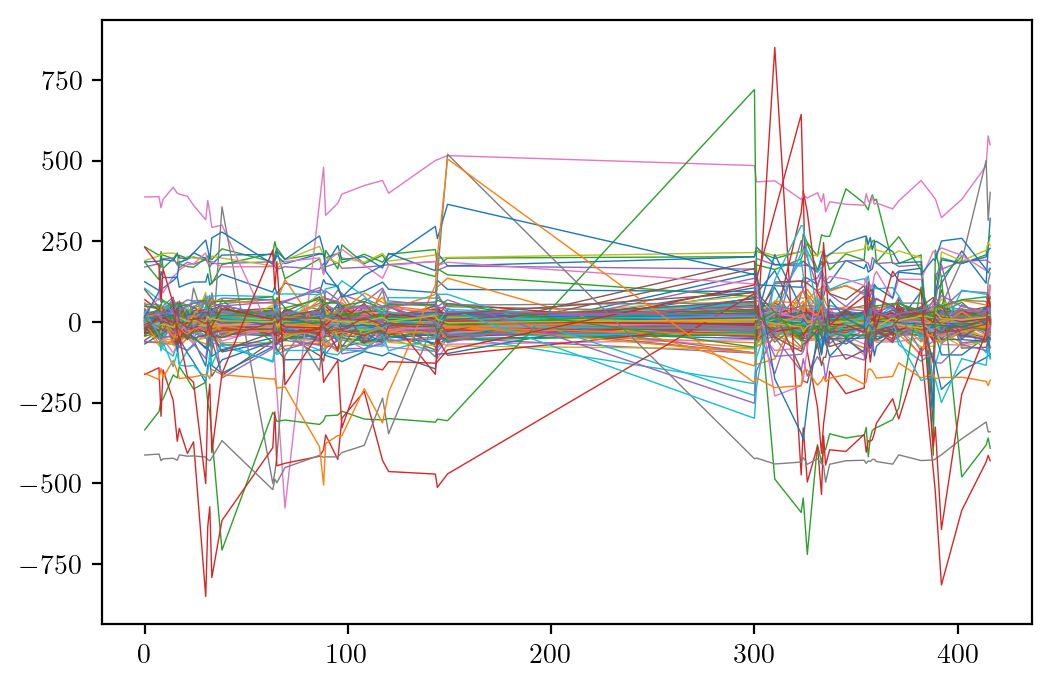

In [237]:
# WITH TELLURICS
for i in range(len(result)):
    # plt.plot(result[i][2], result[i][0], ".-", lw=1, ms=4)
    plt.plot(result[i][2], result[i][0], lw=0.5,)


### Load in tellurics

In [326]:
import copy

fits_data = load_spectra_fits(filenames[0])
order = 71
excalibur_mask  = fits_data['EXCALIBUR_MASK'][order]    # filter by EXCALIBUR_MASK
continuum   = fits_data['continuum'][order][excalibur_mask]
y           = fits_data['spectrum'][order][excalibur_mask]/continuum
y_cor       = copy.deepcopy(y)
y_err       = fits_data['uncertainty'][order][excalibur_mask]/continuum
x           = fits_data['BARY_EXCALIBUR'][order][excalibur_mask]
# x           = fits_data['wavelength'][order][excalibur_mask]
tel         = fits_data['tellurics'][order][excalibur_mask]

y_cor[np.where(tel < 1)] = 1

# tel_mask = tel < 1
# y[tel_mask] = 1

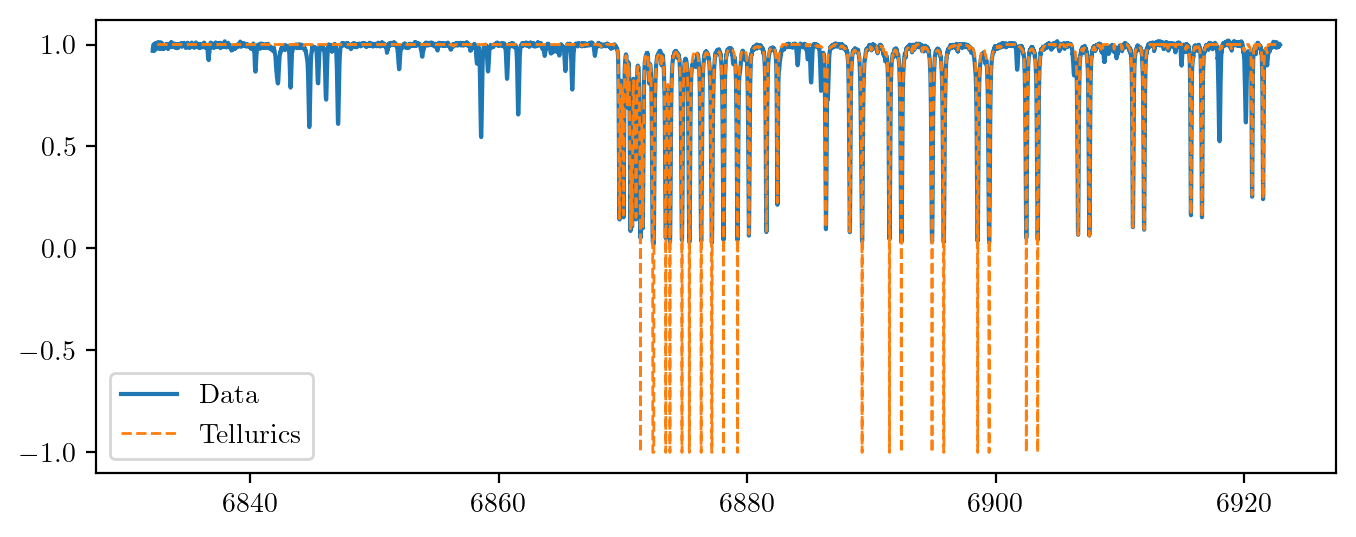

In [332]:
plt.figure(figsize=(8,3))
# plt.plot(x, tel)
# plt.plot(x, y/continuum)
plt.plot(x, y, label="Data")
plt.plot(x, tel, "--", lw=1, label="Tellurics")
plt.legend()

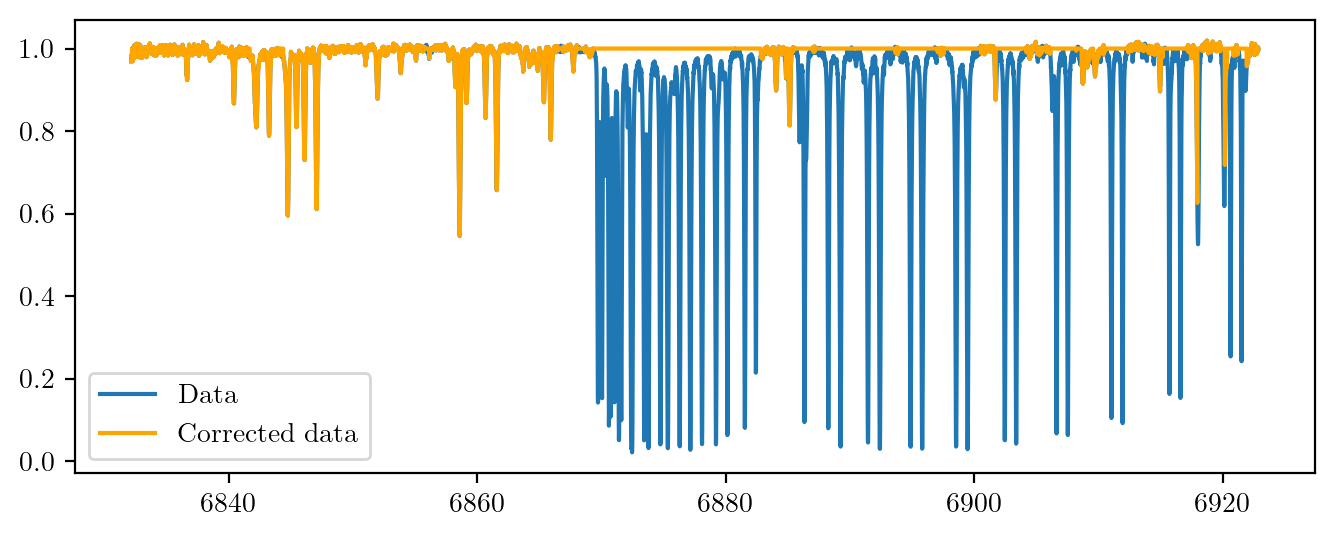

In [335]:
plt.figure(figsize=(8,3))
plt.plot(x, y, label="Data")
plt.plot(x, y_cor, color="orange", label="Corrected data")
plt.legend()